In [134]:
# Install TensorFlow
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten , Convolution2D, MaxPooling2D , Lambda, Conv2D, Activation,Concatenate, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers , initializers, activations
import tensorflow.keras.backend as K
from sklearn.preprocessing import StandardScaler
from joblib import dump, load


import numpy as np
from numpy import random
import matplotlib.pyplot as plt
# import autokeras as ak
import os 
import time
import importlib
import logging
from tqdm import tqdm

importlib.reload(logging)
logging.basicConfig(level = logging.INFO)

# limit GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
        
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    print(e)

logging.info("numpy Version is {}".format(np.__version__))
# logging.info("autokeras Version is {}".format(ak.__version__))
logging.info("tensorflow Version is {}".format(tf.keras.__version__))
logging.info("\n")

!nvidia-smi

INFO:root:numpy Version is 1.19.5
INFO:root:tensorflow Version is 2.4.0
INFO:root:



1 Physical GPUs, 1 Logical GPU
Wed Nov 10 12:22:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM-80GB       On   | 00000000:0B:00.0 Off |                    0 |
| N/A   42C    P0    72W / 400W |  19157MiB / 81251MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                         

In [136]:
%%time
#Load Model
experiment = "dune"


model = {}
nth_range = range(0, 330, 30)[:4]

for i in nth_range:
    if i != 0:
        i-=1
    model.update({"poission_learning_"+str(i): 0}) 
    

for i, (poission_learning, nth) in tqdm(enumerate(zip(model,nth_range))):
    if nth != 0:
        nth-=1
    
    file_path = "/dicos_ui_home/alanchung/ML4NO/Poisson_New_Prediction/Model/" + str(experiment) +  "_poisson_" + str(nth) + "_5_s.h5"

    
    if os.path.isfile(file_path):
        
#         logging.info(str(file_path) +" exists.")

        model[poission_learning] = load_model(file_path, compile=False)

    else:
        logging.info("Please Check Input Files!!!")
        raise ValueError("Please Check Input Files!!!")


        
if model["poission_learning_0"] != 0:
    logging.info("\n")
    model["poission_learning_0"].summary()
else:
    pass
    
logging.info("\n")
logging.info("All Models are loaded!")

4it [00:00,  9.12it/s]
INFO:root:

INFO:root:

INFO:root:All Models are loaded!


Model: "Model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
appearance_input (InputLayer)   [(None, 36, 2)]      0                                            
__________________________________________________________________________________________________
disappearance_input (InputLayer [(None, 36, 2)]      0                                            
__________________________________________________________________________________________________
appearance_conv1d_1 (Conv1D)    (None, 27, 5)        105         appearance_input[0][0]           
__________________________________________________________________________________________________
disappearance_conv1d_1 (Conv1D) (None, 27, 5)        105         disappearance_input[0][0]        
____________________________________________________________________________________________

In [141]:
#======================================================#
training_data = np.load("../Data/n1000000_0910_all_flat.npz")
#======================================================#


"""
Stack Data
"""
#======================================================#

data_all = np.column_stack([training_data["ve_"+str(experiment)][:,:36], training_data["vebar_"+str(experiment)][:,:36], training_data["vu_"+str(experiment)][:,:36], training_data["vubar_"+str(experiment)][:,:36]])

"""
Standardization 
"""
scaler = StandardScaler()
scaler.fit(data_all)

StandardScaler()

In [143]:
%%time
nth_model = "model_5_s"

test_data = np.load('../Data/sample_NuFit0911.npz')
if nth_model == "model_1" or nth_model == "model_2" or nth_model == "model_3" or nth_model == "model_4" :
    data_mid = np.column_stack([test_data["ve_"+str(experiment)][:,:36], test_data["vu_"+str(experiment)][:,:36], test_data["vebar_"+str(experiment)][:,:36], test_data["vubar_"+str(experiment)][:,:36]])

elif nth_model == "model_5" or nth_model == "model_5_s" or nth_model == "model_6" or nth_model == "model_7":
    data_mid = np.column_stack([test_data["ve_"+str(experiment)][:,:36], test_data["vebar_"+str(experiment)][:,:36], test_data["vu_"+str(experiment)][:,:36], test_data["vubar_"+str(experiment)][:,:36]])

    
data_NO_mid = data_mid[0]
data_IO_mid = data_mid[1]

logging.info("Test IO Data Shape:{}".format(data_IO_mid.shape))
logging.info("Test NO Data Shape:{}".format(data_NO_mid.shape))

INFO:root:Test IO Data Shape:(144,)
INFO:root:Test NO Data Shape:(144,)


CPU times: user 4.03 ms, sys: 17 µs, total: 4.05 ms
Wall time: 3.15 ms


In [144]:
%%time

def preprocessing(data,column=2):
    tmp = data.reshape(len(data),column,36)
    tmp = np.array([ element.T for element in tmp])
    
    return tmp

N = 100000#0



IO_or_NO = 0# 0 for NO and 1 for IO


if IO_or_NO == 0:
    logging.info("NO")
    logging.info("True point: theta_23 = {:.2f} \delta_cp = {:.2f}".format(test_data['theta23'][0], test_data['delta'][0]))
    
    if nth_model == "model_1" or nth_model == "model_2" or nth_model == "model_3" or nth_model == "model_4" :
        data_asimov = data_NO_mid.reshape(1,data_NO_mid.shape[0])
        data_asimov = preprocessing(data_asimov,column=4)
#         data_asimov = data_asimov.reshape(len(data_asimov),4,36)
#         data_asimov = np.array([ element.T for element in data_asimov])

        data_poisson = random.poisson(data_NO_mid, size = (N, len(data_NO_mid)))
        data_poisson = preprocessing(data_poisson,column=4)
#         data_poisson = data_poisson.reshape(len(data_poisson),4,36)
#         data_poisson = np.array([ element.T for element in data_poisson])
        
    elif nth_model == "model_5": 
        data_asimov = data_NO_mid.reshape(1,data_NO_mid.shape[0])
        appearance_data_asimov = preprocessing(data_asimov[:,:72],column=2)
        disappearance_data_asimov = preprocessing(data_asimov[:,72:],column=2)
        
        data_poisson = random.poisson(data_NO_mid, size = (N, len(data_NO_mid)))
        appearance_poisson = preprocessing(data_poisson[:,:72],column=2)
        disappearance_poisson = preprocessing(data_poisson[:,72:],column=2)
        
    elif nth_model == "model_5_s": 
        data_asimov = data_NO_mid.reshape(1,data_NO_mid.shape[0])
        data_asimov = scaler.transform(data_asimov)
        appearance_data_asimov = preprocessing(data_asimov[:,:72],column=2)
        disappearance_data_asimov = preprocessing(data_asimov[:,72:],column=2)
        
        data_poisson = random.poisson(data_NO_mid, size = (N, len(data_NO_mid)))
        data_poisson = scaler.transform(data_poisson)
        appearance_poisson = preprocessing(data_poisson[:,:72],column=2)
        disappearance_poisson = preprocessing(data_poisson[:,72:],column=2)
        
    elif nth_model == "model_6":
        
        data_asimov = data_NO_mid.reshape(1,data_NO_mid.shape[0])
        appearance_data_asimov = preprocessing(data_asimov[:,:72],column=2)
        disappearance_data_asimov = preprocessing(data_asimov[:,72:],column=2)
        
        data_asimov_spetcrum_diff = np.column_stack([(data_asimov[:,:36] - data_asimov[:,36:72]),(data_asimov[:,72:108] - data_asimov[:,108:144])])  #11/09 modified 

        data_poisson = random.poisson(data_NO_mid, size = (N, len(data_NO_mid)))
        appearance_poisson = preprocessing(data_poisson[:,:72],column=2)
        disappearance_poisson = preprocessing(data_poisson[:,72:],column=2)
        
        poisson_spetcrum_diff = np.column_stack([(data_poisson[:,:36] - data_poisson[:,36:72]),(data_poisson[:,72:108] - data_poisson[:,108:144])])  #11/09 modified
        
    elif nth_model == "model_7":
        
        data_asimov = data_NO_mid.reshape(1,data_NO_mid.shape[0])
        data_asimov_spetcrum_diff = np.column_stack([(data_asimov[:,:36] - data_asimov[:,36:72]),(data_asimov[:,72:108] - data_asimov[:,108:144])])  #11/09 modified 

        data_poisson = random.poisson(data_NO_mid, size = (N, len(data_NO_mid)))
        poisson_spetcrum_diff = np.column_stack([(data_poisson[:,:36] - data_poisson[:,36:72]),(data_poisson[:,72:108] - data_poisson[:,108:144])])  #11/09 modified
        
        
    
else:
    logging.info("IO")
    logging.info("True point: theta_23 = {:.2f} \delta_cp = {:.2f}".format(test_data['theta23'][1], test_data['delta'][1]))
    
    if nth_model == "model_1" or nth_model == "model_2" or nth_model == "model_3" or nth_model == "model_4" :
        data_asimov = data_IO_mid.reshape(1,data_IO_mid.shape[0])
        data_asimov = preprocessing(data_asimov,column=4)
#         data_asimov = data_asimov.reshape(len(data_asimov),4,36)
#         data_asimov = np.array([ element.T for element in data_asimov])

        data_poisson = random.poisson(data_IO_mid, size = (N, len(data_IO_mid)))
        data_poisson = preprocessing(data_poisson,column=4)
#         data_poisson = data_poisson.reshape(len(data_poisson),4,36)
#         data_poisson = np.array([ element.T for element in data_poisson])
        
    elif nth_model == "model_5":
        data_asimov = data_IO_mid.reshape(1,data_IO_mid.shape[0])
        appearance_data_asimov = preprocessing(data_asimov[:,:72],column=2)
        disappearance_data_asimov = preprocessing(data_asimov[:,72:],column=2)
        
        data_poisson = random.poisson(data_IO_mid, size = (N, len(data_IO_mid)))
        appearance_poisson = preprocessing(data_poisson[:,:72],column=2)
        disappearance_poisson = preprocessing(data_poisson[:,72:],column=2)
        
    elif nth_model == "model_6":
        data_asimov = data_IO_mid.reshape(1,data_IO_mid.shape[0])
        appearance_data_asimov = preprocessing(data_asimov[:,:72],column=2)
        disappearance_data_asimov = preprocessing(data_asimov[:,72:],column=2)
        
        data_asimov_spetcrum_diff = np.column_stack([(data_asimov[:,:36] - data_asimov[:,36:72]),(data_asimov[:,72:108] - data_asimov[:,108:144])])  #11/09 modified 

        
        data_poisson = random.poisson(data_IO_mid, size = (N, len(data_IO_mid)))
        appearance_poisson = preprocessing(data_poisson[:,:72],column=2)
        disappearance_poisson = preprocessing(data_poisson[:,72:],column=2)
    
        poisson_spetcrum_diff = np.column_stack([(data_poisson[:,:36] - data_poisson[:,36:72]),(data_poisson[:,72:108] - data_poisson[:,108:144])])  #11/09 modified 
    
    elif nth_model == "model_7":
        
        data_asimov = data_NO_mid.reshape(1,data_NO_mid.shape[0])
        data_asimov_spetcrum_diff = np.column_stack([(data_asimov[:,:36] - data_asimov[:,36:72]),(data_asimov[:,72:108] - data_asimov[:,108:144])])  #11/09 modified 

        data_poisson = random.poisson(data_NO_mid, size = (N, len(data_NO_mid)))
        poisson_spetcrum_diff = np.column_stack([(data_poisson[:,:36] - data_poisson[:,36:72]),(data_poisson[:,72:108] - data_poisson[:,108:144])])  #11/09 modified
        
    


INFO:root:NO
INFO:root:True point: theta_23 = 49.00 \delta_cp = 195.00


CPU times: user 2.32 s, sys: 123 ms, total: 2.45 s
Wall time: 2.45 s


In [145]:
%%time

def Contour(resolution_dictinary, model_dictinary, bin_size, parameters ,model = "model_1"):
    
    logging.info("==========================================================")
    logging.info("===================== Model: {} =====================".format(model))
    logging.info("==========================================================")
    logging.info("\n")

    for i, poission_learning in enumerate(tqdm(resolution_dictinary)):
    
        if model == "model_1" or model == "model_2":
            if parameters == "delta":
                first_axis, second_axis = 0, 1
            elif parameters == "theta23":
                first_axis, second_axis = 2, 3
            else:
                logging.info("Please Check Input Parameter!!!")
                raise ValueError("Please Check Input Parameter!!!")


            prediction_asimov = model_dictinary[poission_learning].predict(data_asimov)
            prediction_asimov = np.arctan2(prediction_asimov[:,first_axis],prediction_asimov[:,second_axis])
            prediction_asimov = np.where(prediction_asimov > 0 , prediction_asimov, 2*np.pi+prediction_asimov) 
            prediction_asimov = prediction_asimov/np.pi*180

            tmp = model_dictinary[poission_learning].predict(data_poisson)
            tmp = np.arctan2(tmp[:,first_axis],tmp[:,second_axis])
            tmp = np.where(tmp >= 0 , tmp, 2*np.pi+tmp) 
            tmp = tmp/np.pi*180 
        
        elif model == "model_3" or model == "model_4":
            if parameters == "delta":
                
                prediction_asimov = model_dictinary[poission_learning].predict(data_asimov)[0]
                prediction_asimov = np.arctan2(prediction_asimov[:,0],prediction_asimov[:,1])
                prediction_asimov = np.where(prediction_asimov > 0 , prediction_asimov, 2*np.pi+prediction_asimov) 
                prediction_asimov = prediction_asimov/np.pi*180

                tmp = model_dictinary[poission_learning].predict(data_poisson)[0]
                tmp = np.arctan2(tmp[:,0],tmp[:,1])
                tmp = np.where(tmp >= 0 , tmp, 2*np.pi+tmp) 
                tmp = tmp/np.pi*180 
                
            elif parameters == "theta23":
                
                prediction_asimov = model_dictinary[poission_learning].predict(data_asimov)[1]
#                 prediction_asimov = np.arctan2(prediction_asimov[:,0],prediction_asimov[:,1])
                prediction_asimov = np.where(prediction_asimov > 0 , prediction_asimov, 2*np.pi+prediction_asimov) 
                prediction_asimov = prediction_asimov/np.pi*180

                tmp = model_dictinary[poission_learning].predict(data_poisson)[1]
#                 tmp = np.arctan2(tmp[:,0],tmp[:,1])
                tmp = np.where(tmp >= 0 , tmp, 2*np.pi+tmp) 
                tmp = tmp/np.pi*180 
        
        elif model == "model_5" or model == "model_5_s":
            if parameters == "delta":
                
                prediction_asimov = model_dictinary[poission_learning].predict([appearance_data_asimov, disappearance_data_asimov])[0]
                prediction_asimov = np.arctan2(prediction_asimov[:,0],prediction_asimov[:,1])
                prediction_asimov = np.where(prediction_asimov > 0 , prediction_asimov, 2*np.pi+prediction_asimov) 
                prediction_asimov = prediction_asimov/np.pi*180

                tmp = model_dictinary[poission_learning].predict([appearance_poisson,disappearance_poisson])[0]
                tmp = np.arctan2(tmp[:,0],tmp[:,1])
                tmp = np.where(tmp >= 0 , tmp, 2*np.pi+tmp) 
                tmp = tmp/np.pi*180 
                
            elif parameters == "theta23":
                
                prediction_asimov = model_dictinary[poission_learning].predict([appearance_data_asimov, disappearance_data_asimov])[1]
                prediction_asimov = np.where(prediction_asimov > 0 , prediction_asimov, 2*np.pi+prediction_asimov) 
                prediction_asimov = prediction_asimov/np.pi*180

                tmp = model_dictinary[poission_learning].predict([appearance_poisson,disappearance_poisson])[1]
                tmp = np.where(tmp >= 0 , tmp, 2*np.pi+tmp) 
                tmp = tmp/np.pi*180 
                
        elif model == "model_6":
            if parameters == "delta":
                
                prediction_asimov = model_dictinary[poission_learning].predict([appearance_data_asimov, disappearance_data_asimov, data_asimov, data_asimov_spetcrum_diff])[0]
                prediction_asimov = np.arctan2(prediction_asimov[:,0],prediction_asimov[:,1])
                prediction_asimov = np.where(prediction_asimov > 0 , prediction_asimov, 2*np.pi+prediction_asimov) 
                prediction_asimov = prediction_asimov/np.pi*180

                tmp = model_dictinary[poission_learning].predict([appearance_poisson,disappearance_poisson,data_poisson,poisson_spetcrum_diff])[0]
                tmp = np.arctan2(tmp[:,0],tmp[:,1])
                tmp = np.where(tmp >= 0 , tmp, 2*np.pi+tmp) 
                tmp = tmp/np.pi*180 
                
            elif parameters == "theta23":
                
                prediction_asimov = model_dictinary[poission_learning].predict([appearance_data_asimov, disappearance_data_asimov, data_asimov, data_asimov_spetcrum_diff])[1]
                prediction_asimov = np.where(prediction_asimov > 0 , prediction_asimov, 2*np.pi+prediction_asimov) 
                prediction_asimov = prediction_asimov/np.pi*180

                tmp = model_dictinary[poission_learning].predict([appearance_poisson,disappearance_poisson,data_poisson,poisson_spetcrum_diff])[1]
                tmp = np.where(tmp >= 0 , tmp, 2*np.pi+tmp) 
                tmp = tmp/np.pi*180 
        
        elif model == "model_7":
            if parameters == "delta":
                
                prediction_asimov = model_dictinary[poission_learning].predict([data_asimov, data_asimov_spetcrum_diff])[0]
                prediction_asimov = np.arctan2(prediction_asimov[:,0],prediction_asimov[:,1])
                prediction_asimov = np.where(prediction_asimov > 0 , prediction_asimov, 2*np.pi+prediction_asimov) 
                prediction_asimov = prediction_asimov/np.pi*180

                tmp = model_dictinary[poission_learning].predict([data_poisson,poisson_spetcrum_diff])[0]
                tmp = np.arctan2(tmp[:,0],tmp[:,1])
                tmp = np.where(tmp >= 0 , tmp, 2*np.pi+tmp) 
                tmp = tmp/np.pi*180 
                
            elif parameters == "theta23":
                
                prediction_asimov = model_dictinary[poission_learning].predict([data_asimov, data_asimov_spetcrum_diff])[1]
                prediction_asimov = np.where(prediction_asimov > 0 , prediction_asimov, 2*np.pi+prediction_asimov) 
                prediction_asimov = prediction_asimov/np.pi*180

                tmp = model_dictinary[poission_learning].predict([data_poisson,poisson_spetcrum_diff])[1]
                tmp = np.where(tmp >= 0 , tmp, 2*np.pi+tmp) 
                tmp = tmp/np.pi*180 
        
        

        hist, bin_edges = np.histogram(tmp, bins = bin_size)
        max_poi = np.where(hist == hist.max())

        """
        left boundary
        """
        tot_event_num = hist.sum()
        left_area = 0
        for left_boundary in range(len(hist)):
            left_area += hist[left_boundary]
            if left_area/tot_event_num >= 0.34:
                break

        left_boundary = bin_edges[left_boundary]

        """
        right boundary
        """
        tot_event_num = hist.sum()
        right_area = 0
        for right_boundary in np.linspace(len(hist)-1,0,len(hist)):
            right_area += hist[int(right_boundary)]
            if right_area/tot_event_num >= 0.34:
                break

        right_boundary = bin_edges[int(right_boundary)]
        
#         logging.info("\n")
#         logging.info(i)
#         logging.info("prediction asimov: {:.1f}".format(prediction_asimov))
#         logging.info("right_boundary: {:.1f}".format(right_boundary))
#         logging.info("best fit: {:.1f}".format(bin_edges[max_poi][0]))
#         logging.info("left_boundary: {:.1f}".format(left_boundary))
#         logging.info("################")
#         logging.info("\n")
        
        resolution_dictinary[poission_learning]["poission_prediction"] = tmp
        resolution_dictinary[poission_learning]["asimov"] = prediction_asimov
        resolution_dictinary[poission_learning]["hist"] = hist
        resolution_dictinary[poission_learning]["best_fit"] = bin_edges[max_poi][0]
        resolution_dictinary[poission_learning]["p_yerr"] = right_boundary
        resolution_dictinary[poission_learning]["n_yerr"] = left_boundary
    
    return resolution_dictinary
    
    
theta23_resolution,  delta_resolution = {}, {}   

for i in nth_range:
    if i != 0:
        i -= 1
        
    theta23_resolution.update({"poission_learning_"+str(i): {"poission_prediction":0, "asimov": 0, "hist": 0, "best_fit": 0, "p_yerr": 0 , "n_yerr": 0 , },}) 
    delta_resolution.update({"poission_learning_"+str(i): {"poission_prediction":0, "asimov": 0, "hist": 0, "best_fit": 0, "p_yerr": 0 , "n_yerr": 0 , },}) 


    
# bins_theta23 = np.linspace(38.9, 51.1, 1000)
bins_theta23 = np.linspace(0, 360, 30000)
theta23_resolution = Contour(theta23_resolution, model, bins_theta23, parameters="theta23", model = nth_model)
        
bins_delta = np.linspace(0, 360, 1000)
delta_resolution = Contour(delta_resolution, model, bins_delta, parameters="delta", model = nth_model)
    
    

INFO:root:==========================================================
INFO:root:===================== Model: model_5_s =====================
INFO:root:==========================================================
INFO:root:

100%|██████████| 4/4 [00:21<00:00,  5.43s/it]
INFO:root:==========================================================
INFO:root:===================== Model: model_5_s =====================
INFO:root:==========================================================
INFO:root:

100%|██████████| 4/4 [00:21<00:00,  5.26s/it]

CPU times: user 52.4 s, sys: 5.3 s, total: 57.6 s
Wall time: 42.7 s


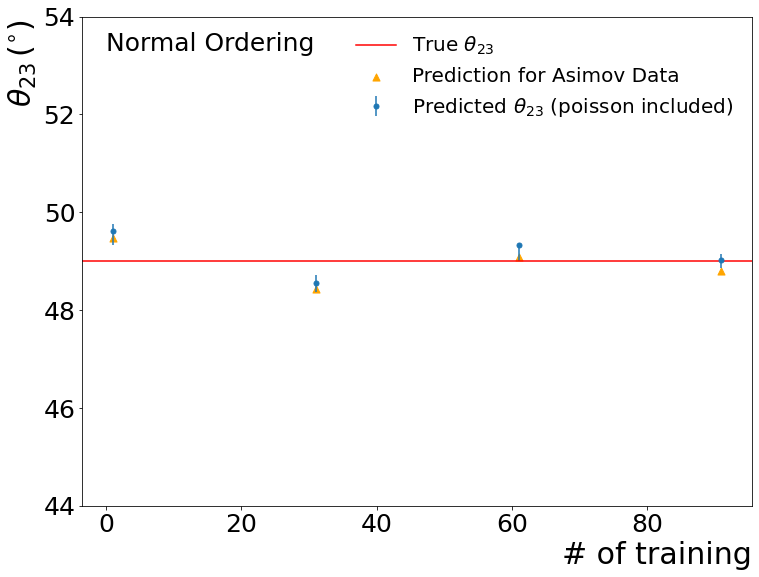

CPU times: user 316 ms, sys: 1.09 s, total: 1.4 s
Wall time: 316 ms


In [146]:
%%time

fig, ax = plt.subplots(1,1, figsize=(12,9))


poission_learning = np.linspace(0,300,301)[nth_range] + 1
prediction_asimov = [theta23_resolution[poission_learning]["asimov"] for poission_learning in theta23_resolution]
best_fit = [theta23_resolution[poission_learning]["best_fit"] for poission_learning in theta23_resolution]
p_yerr = np.array([theta23_resolution[poission_learning]["p_yerr"] for poission_learning in theta23_resolution]) - np.array(best_fit)
n_yerr = np.array(best_fit) - np.array([theta23_resolution[poission_learning]["n_yerr"] for poission_learning in theta23_resolution])
uncertainty = [n_yerr, p_yerr]

plt.scatter(poission_learning, prediction_asimov, color='orange', marker = "^", s=50, label="Prediction for Asimov Data")
plt.errorbar(poission_learning, best_fit, yerr=uncertainty, fmt='o',ms=5, label="Predicted $\\theta_{23}$ (poisson included)")
plt.axhline(y=test_data['theta23'][IO_or_NO] , color='r', linestyle='-', label="True $\\theta_{23}$")


if IO_or_NO == 0:
    plt.text(x=0.001,y=53.3, s="Normal Ordering", fontsize=25 )
elif IO_or_NO == 1:
    plt.text(x=0.001,y=53.3, s="Inverse Ordering", fontsize=25 )



ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
# plt.xlim((-0.1,1.1))
plt.ylim((44, 54))
plt.xlabel("# of training", fontsize=30,horizontalalignment='right',x=1) 
plt.ylabel("$\\theta_{23}\,(^{\circ})$ ", fontsize=30, horizontalalignment='right',y=1)

plt.legend(loc="best",ncol=1,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0)
 


plt.show()

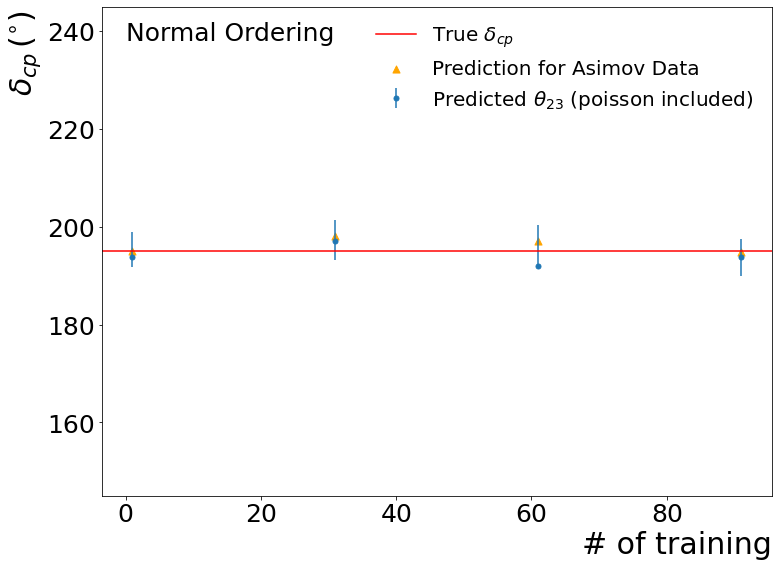

CPU times: user 216 ms, sys: 169 ms, total: 385 ms
Wall time: 204 ms


In [147]:
%%time

fig, ax = plt.subplots(1,1, figsize=(12,9))


poission_learning = np.linspace(0,300,301)[nth_range] + 1
prediction_asimov = [delta_resolution[poission_learning]["asimov"] for poission_learning in delta_resolution]
best_fit = [delta_resolution[poission_learning]["best_fit"] for poission_learning in delta_resolution]
p_yerr = np.array([delta_resolution[poission_learning]["p_yerr"] for poission_learning in delta_resolution]) - np.array(best_fit)
n_yerr = np.array(best_fit) - np.array([delta_resolution[poission_learning]["n_yerr"] for poission_learning in delta_resolution])
uncertainty = [n_yerr, p_yerr]

plt.scatter(poission_learning, prediction_asimov, color='orange', marker = "^", s=50, label="Prediction for Asimov Data")
plt.errorbar(poission_learning, best_fit, yerr=uncertainty, fmt='o',ms=5, label="Predicted $\\theta_{23}$ (poisson included)")
plt.axhline(y=test_data['delta'][IO_or_NO] , color='r', linestyle='-', label="True $\delta_{cp}$")

if IO_or_NO == 0:
    plt.text(x=0.001,y=238, s="Normal Ordering", fontsize=25 )
    plt.ylim((145, 245))
elif IO_or_NO == 1:
    plt.text(x=0.001,y=328, s="Inverse Ordering", fontsize=25 )
    plt.ylim((236, 336))


ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
# plt.xlim((-0.1,1.1))
plt.xlabel("# of training", fontsize=30,horizontalalignment='right',x=1) 
plt.ylabel("$\delta_{cp}\,(^{\circ})$ ", fontsize=30, horizontalalignment='right',y=1)

plt.legend(loc="best",ncol=1,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0)
 


plt.show()

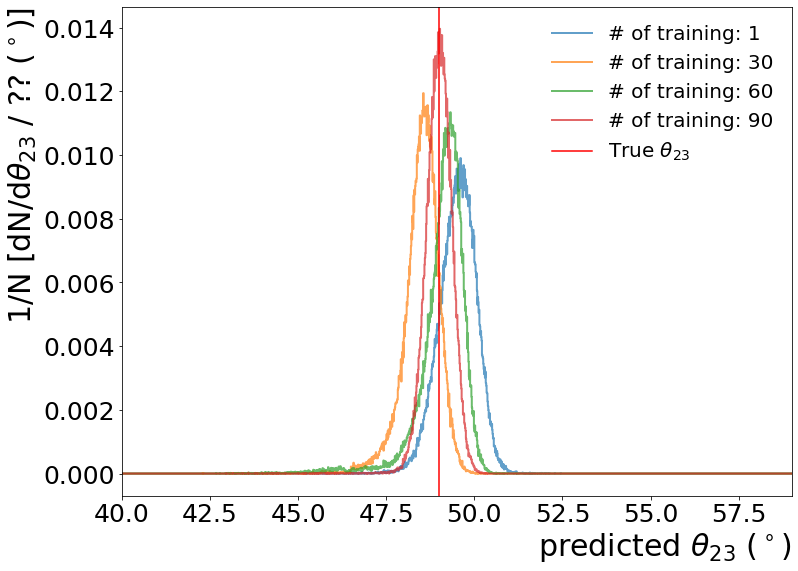

CPU times: user 324 ms, sys: 184 ms, total: 509 ms
Wall time: 328 ms


In [148]:
%%time
fig, ax = plt.subplots(1,1, figsize=(12,9))

for i in nth_range:
    if i != 0 :
        i -= 1
    hist, bins = theta23_resolution["poission_learning_"+str(i)]["hist"], bins_theta23
#     hist, bins = theta23_resolution["poission_learning_"+str(i)]["hist"], np.linspace(38.9, 51.1, 1000)
    
    plt.step(bins[:-1], 
             hist.astype(np.float32) / hist.sum() ,
    #          hist.astype(np.float32) ,
             where='mid',
             linewidth=2, 
             alpha=0.7,
             label="# of training: {:}".format(i+1)
            )
    
    
plt.axvline(x=49.00 , color='r', linestyle='-', label="True $\\theta_{23}$")

ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
plt.xlim((40,59))
# plt.ylim((0, 0.025))
plt.xlabel("predicted $\\theta_{23}$ ($^\circ$)", fontsize=30,horizontalalignment='right',x=1) 
plt.ylabel("1/N [dN/d$\\theta_{23}$ / ?? ($^\circ$)]", fontsize=30, horizontalalignment='right',y=1)

plt.legend(loc="best",ncol=1,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0)
    


plt.show()

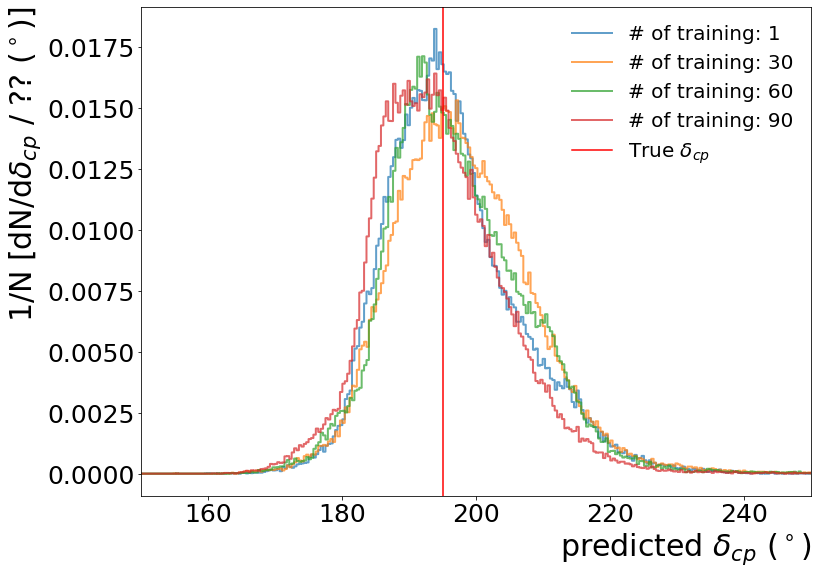

CPU times: user 260 ms, sys: 168 ms, total: 428 ms
Wall time: 246 ms


In [149]:
%%time
fig, ax = plt.subplots(1,1, figsize=(12,9))

for i in nth_range:
    if i != 0 :
        i -= 1
    hist, bins = delta_resolution["poission_learning_"+str(i)]["hist"], bins_delta
    plt.step(bins[:-1], 
             hist.astype(np.float32) / hist.sum() ,
    #          hist.astype(np.float32) ,
             where='mid',
             linewidth=2, 
             alpha=0.7,
             label="# of training: {:}".format(i+1)
            )

plt.axvline(x=195.00 , color='r', linestyle='-', label="True $\delta_{cp}$")
    
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
plt.xlim((150,250))
# plt.ylim((0., 0.18))
plt.xlabel("predicted $\delta_{cp}$ ($^\circ$)", fontsize=30,horizontalalignment='right',x=1) 
plt.ylabel("1/N [dN/d$\delta_{cp}$ / ?? ($^\circ$)]", fontsize=30, horizontalalignment='right',y=1)

plt.legend(loc="best",ncol=1,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0)
    


plt.show()

In [150]:
#總資料組數
N_DUNE = 92
N_T2HK = 36
N_DUT2 = 96

In [151]:
theta23_DUNE = []
delta_cp_DUNE = []
chi_DUNE = []
theta23_T2HK = []
delta_cp_T2HK = []
chi_T2HK = []
theta23_DUT2 = []
delta_cp_DUT2 = []
chi_DUT2 = []

In [152]:
%%time
#Import txt檔
f_DUNE = open("../Data/chi_square-4-2_figB_DUNE.txt")
for i in range(N_DUNE):
    s = f_DUNE.readline().split()
    array = []
    for j in range(len(s)) :
        array.append(float(s[j])) 
    theta23_DUNE.append(array[0])
    delta_cp_DUNE.append(array[1]) 
    chi_DUNE.append(array[2])
f_DUNE.close()
f_T2HK = open("../Data/chi_square-4-2_figB_T2HK.txt")
for i in range(N_T2HK):
    s = f_T2HK.readline().split()
    array = []
    for j in range(len(s)) :
        array.append(float(s[j])) 
    theta23_T2HK.append(array[0])
    delta_cp_T2HK.append(array[1]) 
    chi_T2HK.append(array[2])
f_T2HK.close()
f_DUT2 = open("../Data/chi_square-4-2_figB_DUT2.txt")
for i in range(N_DUT2):
    s = f_DUT2.readline().split()
    array = []
    for j in range(len(s)) :
        array.append(float(s[j])) 
    theta23_DUT2.append(array[0])
    delta_cp_DUT2.append(array[1]) 
    chi_DUT2.append(array[2])
f_DUT2.close()

CPU times: user 1.19 ms, sys: 917 µs, total: 2.1 ms
Wall time: 4.68 ms


In [153]:
theta23_DUNE = np.array(theta23_DUNE)
delta_cp_DUNE = np.array(delta_cp_DUNE)
chi_DUNE = np.array(chi_DUNE)
theta23_T2HK = np.array(theta23_T2HK)
delta_cp_T2HK = np.array(delta_cp_T2HK)
chi_T2HK = np.array(chi_T2HK)
theta23_DUT2 = np.array(theta23_DUT2)
delta_cp_DUT2 = np.array(delta_cp_DUT2)
chi_DUT2 = np.array(chi_DUT2)

In [154]:
%%time
x0 = np.linspace(min(theta23_DUNE)-3, max(theta23_DUNE)+3, 68)
y0 = np.linspace(min(delta_cp_DUNE)-6, max(delta_cp_DUNE)+6, 20)
X0, Y0 = np.meshgrid(x0, y0)
Z0 = np.zeros((len(X0),len(X0[0])))

for i in range(len(theta23_DUNE)):
    a = np.where(X0 == theta23_DUNE[i])[1][0]
    b = np.where(Y0 == delta_cp_DUNE[i])[0][0]
    Z0[b][a] = 1

x1 = np.linspace(min(theta23_T2HK)-3, max(theta23_T2HK)+3, 65)
y1 = np.linspace(min(delta_cp_T2HK)-6, max(delta_cp_T2HK)+6, 14)
X1, Y1 = np.meshgrid(x1, y1)
Z1 = np.zeros((len(X1),len(X1[0])))

for i in range(len(theta23_T2HK)):
    a = np.where(X1 == theta23_T2HK[i])[1][0]
    b = np.where(Y1 == delta_cp_T2HK[i])[0][0]
    Z1[b][a] = 1

x2 = np.linspace(min(theta23_DUT2)-3, max(theta23_DUT2)+3, 129)
y2 = np.linspace(min(delta_cp_DUT2)-6, max(delta_cp_DUT2)+6, 25)
X2, Y2 = np.meshgrid(x2, y2)
Z2 = np.zeros((len(X2),len(X2[0])))

for i in range(len(theta23_DUT2)):
    a = np.where(X2 == theta23_DUT2[i])[1][0]
    b = np.where(Y2 == delta_cp_DUT2[i])[0][0]
    Z2[b][a] = 1

CPU times: user 7.65 ms, sys: 37 µs, total: 7.69 ms
Wall time: 6.84 ms


In [155]:
theta23_resolution.keys()

dict_keys(['poission_learning_0', 'poission_learning_29', 'poission_learning_59', 'poission_learning_89'])

In [156]:
%%time

index = 89
input_theta23 = theta23_resolution["poission_learning_"+str(index)]["poission_prediction"]
input_theta23 = input_theta23.reshape(len(input_theta23),)
input_delta = delta_resolution["poission_learning_"+str(index)]["poission_prediction"]


bins_theta23_globes = np.linspace(0, 360, int(360/(x0[1]-x0[0])))
bins_delta_globes  = np.linspace(0, 360, int(360/(y0[1]-y0[0])))

likeliregion, xedges, yedges = np.histogram2d(input_theta23, input_delta, bins = [bins_theta23_globes, bins_delta_globes])
likeliregion = likeliregion.T

max_poi = np.where(likeliregion == likeliregion.max())
print("Maximum: theta23 {}, delta {} ".format(xedges[max_poi[1]],yedges[max_poi[0]]))
sorted_list = np.sort(likeliregion.reshape((len(xedges)-1)*(len(yedges)-1)))[::-1]

tot_event_num = sorted_list.sum()

onesigma = 0
for i in range(len(sorted_list)):
    onesigma += sorted_list[i]
    if onesigma/tot_event_num >= 0.68:
        one_sigma_num = sorted_list[i]
        break
        
twosigma = 0
for i in range(len(sorted_list)):
    twosigma += sorted_list[i]        
    if twosigma/tot_event_num >= 0.95:
        two_sigma_num = sorted_list[i]
        break

one_sigma_region = np.where(likeliregion < one_sigma_num, 0, likeliregion )
one_sigma_region_boundary = np.where(one_sigma_region > 0, 1, one_sigma_region )
one_sigma_allowed_region = np.where(one_sigma_region_boundary != 0)

two_sigma_region = np.where(likeliregion < two_sigma_num, 0, likeliregion )
two_sigma_region_boundary = np.where(two_sigma_region > 0, 1, two_sigma_region )
two_sigma_allowed_region = np.where(two_sigma_region_boundary != 0)

xaxis, yaxis = (xedges[:-1] + xedges[1:])/2, (yedges[:-1] + yedges[1:])/2

Maximum: theta23 [48.92718177], delta [189.05027933] 
CPU times: user 34.9 ms, sys: 1.99 ms, total: 36.8 ms
Wall time: 35.9 ms


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: No contour levels were found within the data range.


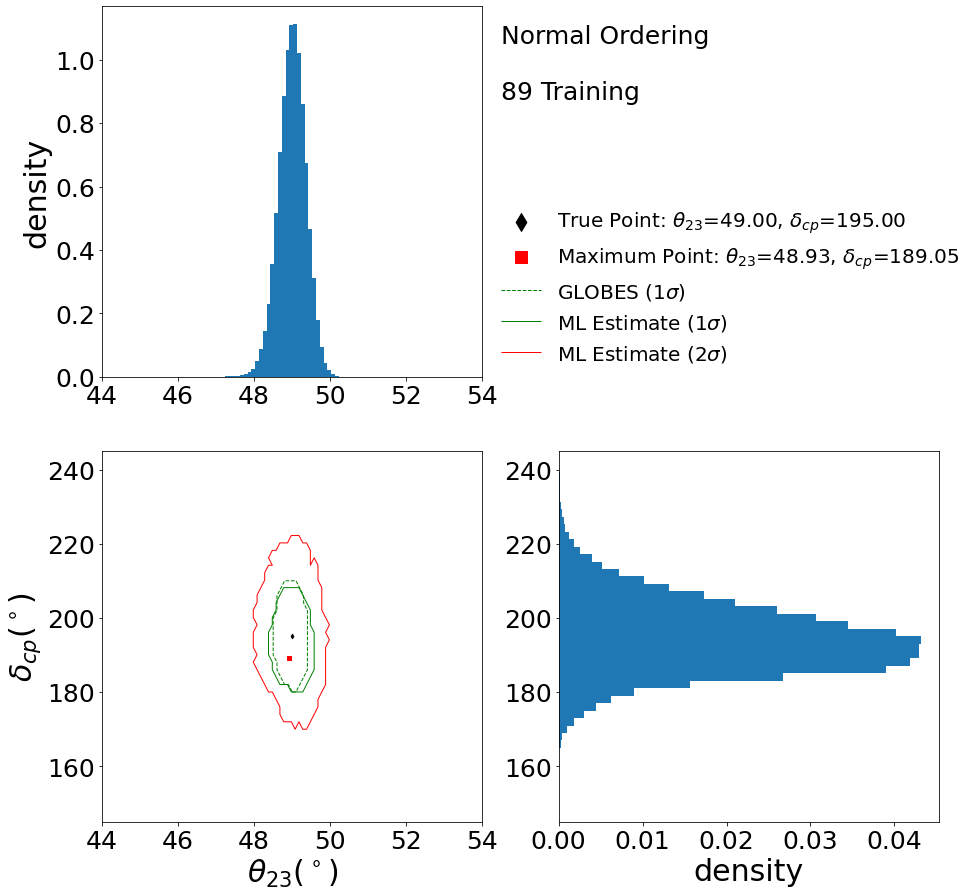

In [157]:
fig, ax = plt.subplots(1,1, figsize=(15,15))

#=========================== Upper Left Corner
plot_axis = plt.subplot(2,2,1)
"""
ML
"""
plot_axis.hist(input_theta23,density=1,bins=bins_theta23_globes)
if IO_or_NO == 0:
    plot_axis.set_xlim((44,54))
elif IO_or_NO == 1:
    plot_axis.set_xlim((44,54))
plot_axis.tick_params(axis='x', labelsize=25)
plot_axis.tick_params(axis='y', labelsize=25)
plot_axis.set_ylabel(r'density', fontsize=30)
#===========================




#=========================== Down Right Corner
plot_axis = plt.subplot(2,2,4)
"""
ML
"""
plot_axis.hist(input_delta,orientation="horizontal",density=1, bins=bins_delta_globes)
if IO_or_NO == 0:
    plot_axis.set_ylim((145,245))
elif IO_or_NO == 1:
    plot_axis.set_ylim((236, 336))
plot_axis.tick_params(axis='x', labelsize=25)
plot_axis.tick_params(axis='y', labelsize=25)
plot_axis.set_xlabel(r'density', fontsize=30)
#===========================


#=========================== Down Left Corner
plot_axis = plt.subplot(2,2,3)


if IO_or_NO == 0:
    plot_axis.scatter(test_data['theta23'][0], test_data['delta'][0], marker="d", c="k", s=10, label = "True Point: $\\theta_{23}$=%.2f, $\delta_{cp}$=%.2f" %(test_data['theta23'][0], test_data['delta'][0]))
else:
    plot_axis.scatter(test_data['theta23'][1], test_data['delta'][1], marker="d", c="k", s=10, label = "True Point: $\\theta_{23}$=%.2f, $\delta_{cp}$=%.2f" %(test_data['theta23'][1], test_data['delta'][1]))

plot_axis.scatter(xedges[max_poi[1]],yedges[max_poi[0]], marker="s", c="r", s=10, label = "Maximum Point: $\\theta_{23}$=%.2f, $\delta_{cp}$=%.2f" %(xedges[max_poi[1]][0], yedges[max_poi[0]][0]))
# plot_axis.scatter(xedges_asimov[max_poi_asimov[1]],yedges_asimov[max_poi_asimov[0]], marker="d", c="blue", s=5, label = "maximum point: $\\theta_{23}$=%.2f, $\delta_{cp}$=%.2f" %(xedges_asimov[max_poi_asimov[1]][0], yedges_asimov[max_poi_asimov[0]][0]))

    
"""
globes
"""
DUT2 = plot_axis.contour(X0, Y0, Z0, 0, colors='green', linestyles="--", linewidths=1 )
DUT2.collections[0].set_label("GLOBES (1$\sigma$)")

# DUT2 = plot_axis.contour(X1, Y1, Z1, 0, colors='blue', linestyles="-", linewidths=1)
# DUT2.collections[0].set_label("T2HK")

# DUT2 = plot_axis.contour(X2, Y2, Z2, 0, colors='blue', linestyles="-", linewidths=1)
# DUT2.collections[0].set_label("DUNE + T2HK")



# """
# ML (Asimov)
# """
# CS_1_sigma_asimov = plt.contour(xaxis_asimov, yaxis_asimov, one_sigma_region_boundary_asimov, 0, colors='green', linestyles=":", linewidths=1)
# CS_2_sigma_asimov = plt.contour(xaxis_asimov, yaxis_asimov, two_sigma_region_boundary_asimov, 0, colors='red', linestyles=":", linewidths=1)
# CS_1_sigma_asimov.collections[0].set_label("Learnt Asimov (1$\sigma$)")
# CS_2_sigma_asimov.collections[0].set_label("Learnt Asimov (2$\sigma$)")



"""
ML (Poisson)
"""
CS_1_sigma = plt.contour(xaxis, yaxis, one_sigma_region_boundary, 0, colors='green', linestyles="-", linewidths=1)
CS_2_sigma = plt.contour(xaxis, yaxis, two_sigma_region_boundary, 0, colors='red', linestyles="-", linewidths=1)
CS_1_sigma.collections[0].set_label("ML Estimate (1$\sigma$)")
CS_2_sigma.collections[0].set_label("ML Estimate (2$\sigma$)")


plot_axis.set_xlabel(r'$\theta_{23} $($^\circ$)', fontsize=30)
plot_axis.set_ylabel(r'$\delta_{cp} $($^\circ$)', fontsize=30)
if IO_or_NO == 0:
    plot_axis.set_ylim((145,245))
    plot_axis.set_xlim((44,54))
elif IO_or_NO == 1:
    plot_axis.set_ylim((236, 336))
    plot_axis.set_xlim((44,54))
else:
    raise ValueError("aaaa")
    
    
plot_axis.tick_params(axis='x', labelsize=25)
plot_axis.tick_params(axis='y', labelsize=25)
#===========================
                              
    

#=========================== Whole Figure Setting

if IO_or_NO == 0:
    plt.text(x=54.5,y=355, s="Normal Ordering", fontsize=25 )
    plt.text(x=54.5,y=340, s= str(index)+" Training", fontsize=25 )
    
elif IO_or_NO == 1:
    plt.text(x=54.5,y=440, s="Inverse Ordering", fontsize=25 )
    plt.text(x=54.5,y=430, s= str(index)+" Training", fontsize=25 ) 
    
# plt.subplots_adjust(wspace=0.15, hspace=0.01)
plt.legend(bbox_to_anchor=(2.3, 1.7), ncol=1,fontsize=20, markerscale=4, edgecolor = "w",fancybox=False, framealpha=0)
# plt.savefig("./Plots/"+str(experiment)+"_"+str("to_5GeV")+"_"+str(ordering)+"_std_"+str(int(round(np.logspace(-3, np.log10(2), 40)[index],2)*100))+".pdf", transparent=True, bbox_inches='tight') 
plt.show()